In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns

# Facebook _data_inwi

In [5]:
with open('../../../data/official_pages/facebook_data_backup/inwi.ma_facebook_posts_with_comments_20250601_035335.json', 'r', encoding='utf-8') as f:
    data = json.load(f)["data"]

In [6]:
print(f"Type des données chargées : {type(data)}")

Type des données chargées : <class 'list'>


In [7]:
posts_df = pd.DataFrame(data if isinstance(data, list) else [data])
if 'comments' in posts_df.columns:
    posts_df = posts_df.drop(columns=['comments'])

#Convertir created_time en datetime
posts_df['created_time'] = pd.to_datetime(posts_df['created_time'])

In [8]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   post_id              100 non-null    object        
 1   source_id            100 non-null    object        
 2   created_time         100 non-null    datetime64[ns]
 3   permalink            100 non-null    object        
 4   page_id              100 non-null    object        
 5   page_name            100 non-null    object        
 6   message              100 non-null    object        
 7   media_type           100 non-null    object        
 8   media_url            100 non-null    object        
 9   thumbnail_url        100 non-null    object        
 10  can_share            100 non-null    bool          
 11  shares               100 non-null    int64         
 12  can_comment          100 non-null    bool          
 13  comments_count       100 non-null   

In [9]:
posts_df.isnull().sum()

post_id                0
source_id              0
created_time           0
permalink              0
page_id                0
page_name              0
message                0
media_type             0
media_url              0
thumbnail_url          0
can_share              0
shares                 0
can_comment            0
comments_count         0
can_like               0
like_count             0
hashtags               0
mentions               0
platform               0
brand_name             0
kafka_metadata         0
collection_metadata    0
statistics             0
dtype: int64

In [10]:

# 1. Colonnes à vérifier pour présence de chaînes vides
text_fields = [
    "post_id", "source_id", "created_time", "permalink", "page_id",
    "page_name", "message", "media_type", "media_url", "thumbnail_url"
]

print("🧪 Champs texte vides :")
for col in text_fields:
    empty_count = (posts_df[col].astype(str).str.strip() == '').sum()
    print(f" - {col}: {empty_count} lignes vides")

# 2. Vérification created_time valide
print("\n🕒 Vérification des timestamps invalides :")
invalid_dates = pd.to_datetime(posts_df["created_time"], errors="coerce").isna().sum()
print(f" - created_time non valides : {invalid_dates}")

# 3. Valeurs uniques des booléens
print("\n🔁 Valeurs uniques booléennes :")
for col in ["can_share", "can_comment"]:
    print(f" - {col}: {posts_df[col].nunique()} valeurs uniques ({posts_df[col].unique()})")

# 4. Champs numériques à 0
print("\n🔢 Champs numériques avec des zéros :")
for col in ["shares", "comments_count", "like_count"]:
    zero_count = (posts_df[col] == 0).sum()
    print(f" - {col} == 0 : {zero_count} lignes")

# 5. Listes : type check et nombre de listes vides
print("\n📚 Vérification des champs listes :")
for col in ["hashtags", "mentions"]:
    non_lists = posts_df[~posts_df[col].apply(lambda x: isinstance(x, list))].shape[0]
    empty_lists = posts_df[posts_df[col].apply(lambda x: isinstance(x, list) and len(x) == 0)].shape[0]
    print(f" - {col} : {non_lists} non-listes / {empty_lists} listes vides")

🧪 Champs texte vides :
 - post_id: 0 lignes vides
 - source_id: 0 lignes vides
 - created_time: 0 lignes vides
 - permalink: 0 lignes vides
 - page_id: 0 lignes vides
 - page_name: 0 lignes vides
 - message: 1 lignes vides
 - media_type: 1 lignes vides
 - media_url: 1 lignes vides
 - thumbnail_url: 1 lignes vides

🕒 Vérification des timestamps invalides :
 - created_time non valides : 0

🔁 Valeurs uniques booléennes :
 - can_share: 1 valeurs uniques ([ True])
 - can_comment: 1 valeurs uniques ([ True])

🔢 Champs numériques avec des zéros :
 - shares == 0 : 0 lignes
 - comments_count == 0 : 0 lignes
 - like_count == 0 : 0 lignes

📚 Vérification des champs listes :
 - hashtags : 0 non-listes / 11 listes vides
 - mentions : 0 non-listes / 100 listes vides


In [11]:
posts_df = posts_df.drop(columns=["kafka_metadata", "collection_metadata", "statistics"])

In [12]:
 #Ajouter des colonnes utiles
posts_df['day'] = posts_df['created_time'].dt.date
posts_df['hour'] = posts_df['created_time'].dt.hour
posts_df['message_length'] = posts_df['message'].fillna('').apply(len)

In [23]:
#Aperçu général
print(posts_df.describe(include='all'))
print(posts_df.dtypes)
print(posts_df.head())
print(posts_df["post_id"].nunique())

                 post_id        source_id                   created_time  \
count                100              100                            100   
unique               100                1                            NaN   
top     1088318753342933  100064944541507                            NaN   
freq                   1              100                            NaN   
mean                 NaN              NaN  2025-04-23 21:31:25.929999872   
min                  NaN              NaN            2025-03-16 22:53:20   
25%                  NaN              NaN            2025-03-30 21:18:22   
50%                  NaN              NaN            2025-04-26 01:25:30   
75%                  NaN              NaN            2025-05-13 14:44:42   
max                  NaN              NaN            2025-05-31 21:18:44   
std                  NaN              NaN                            NaN   

                                                permalink          page_id  \
count    

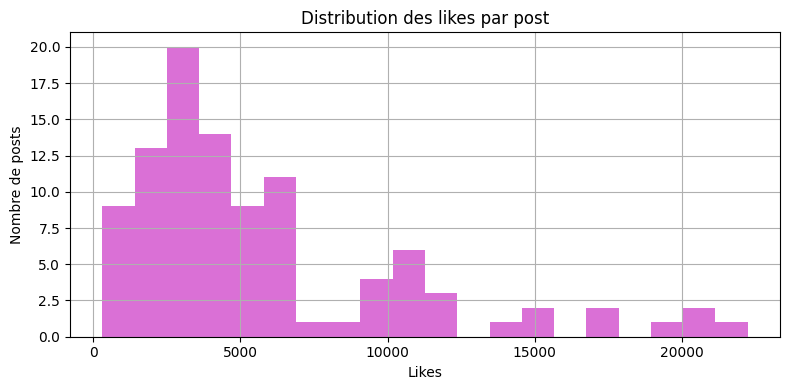

In [14]:

# 1. Histogramme des likes
plt.figure(figsize=(8, 4))
plt.hist(posts_df['like_count'], bins=20, color='orchid')
plt.title("Distribution des likes par post")
plt.xlabel("Likes")
plt.ylabel("Nombre de posts")
plt.grid(True)
plt.tight_layout()
plt.show()

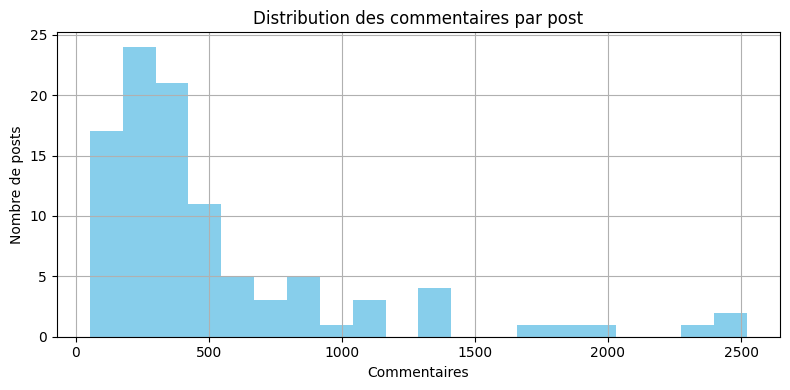

In [15]:
plt.figure(figsize=(8, 4))
plt.hist(posts_df['comments_count'], bins=20, color='skyblue')
plt.title("Distribution des commentaires par post")
plt.xlabel("Commentaires")
plt.ylabel("Nombre de posts")
plt.grid(True)
plt.tight_layout()
plt.show()

     month  count
0  2025-03     29
1  2025-04     27
2  2025-05     44


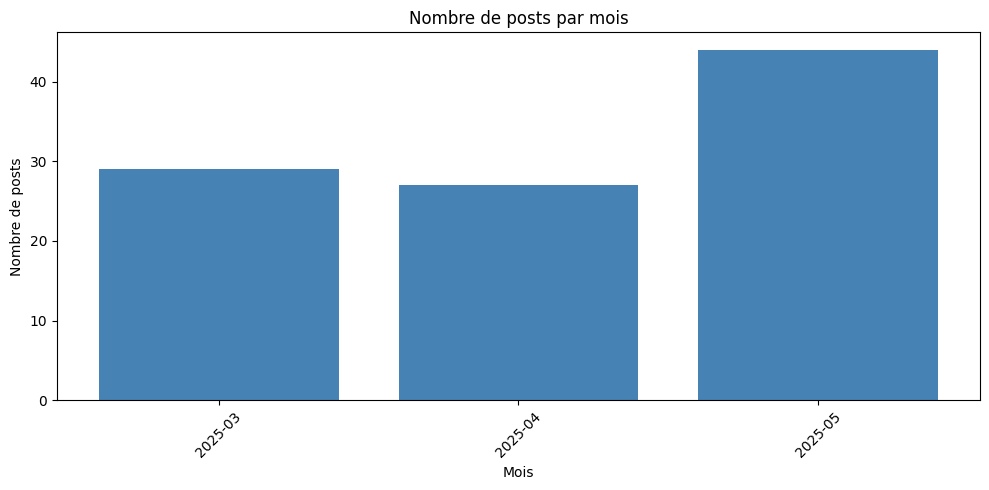

In [16]:
posts_df['month'] = posts_df['created_time'].dt.to_period('M').astype(str)

# 3. Compter les posts par mois
posts_per_month = posts_df.groupby('month').size().reset_index(name='count')

# 4. Afficher les valeurs
print(posts_per_month)

# 5. Visualisation
plt.figure(figsize=(10, 5))
plt.bar(posts_per_month['month'], posts_per_month['count'], color='steelblue')
plt.title("Nombre de posts par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

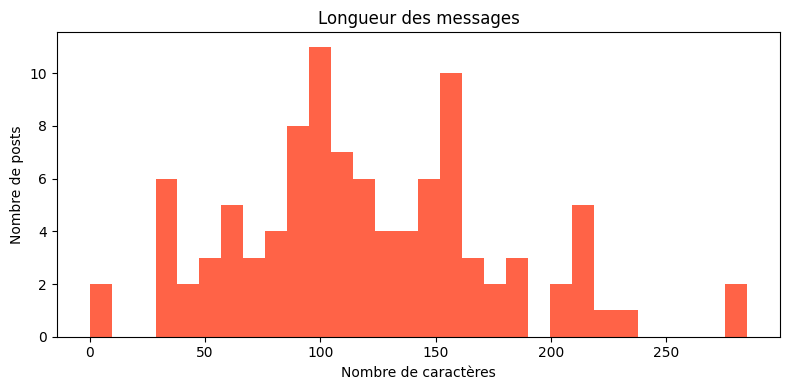

In [17]:
# Longueur des messages
plt.figure(figsize=(8, 4))
plt.hist(posts_df['message_length'], bins=30, color='tomato')
plt.title("Longueur des messages")
plt.xlabel("Nombre de caractères")
plt.ylabel("Nombre de posts")
plt.tight_layout()
plt.show()

In [18]:
all_comments = []

for post in data:
    comments = post.get('comments', [])
    
    # Vérifie que la liste n'est pas vide
    if comments:
        for comment in comments:
            # Extraire uniquement les commentaires avec metadata valide
            metadata = comment.get('comment_metadata', {})
            if 'parent_post_id' in metadata:
                comment_flat = {
                    'comment_id': comment.get('comment_id'),
                    'message': comment.get('message'),
                    'created_time': comment.get('created_time'),
                    'like_count': int(comment.get('like_count', 0)),
                    'reply_count': comment.get('reply_count', 0),
                    'user_id': comment.get('user_id'),
                    'user_name': comment.get('user_name'),
                    'comment_url': comment.get('comment_url'),
                    'parent_post_id': metadata['parent_post_id'],
                    'comment_length': metadata.get('comment_length'),
                    'comment_engagement_score': metadata.get('comment_engagement_score'),
                    'has_hashtags': metadata.get('has_hashtags'),
                    'has_mentions': metadata.get('has_mentions'),
                    'platform': comment.get('platform'),
                    'brand_name': comment.get('brand_name')
                }
                all_comments.append(comment_flat)

# Créer le DataFrame à partir de la liste
comments_df = pd.DataFrame(all_comments)

# Conversion en datetime
comments_df['created_time'] = pd.to_datetime(comments_df['created_time'])

# Aperçu
print(comments_df.head())

         comment_id                                            message  \
0  1818153165710217  Vous n avez aucune honte ?!! 3 mois que je pay...   
1   563603726619009              الف مبروك عليك يااسد اشرف حكيمي مرحبا   
2   682503821419212                    حنا معاك انوي وباقين نويت الخير   
3  1853962871839803           ريزو من صباح هو مقطوع علينا شوفو لينا حل   
4   711159261279085  سلام أنا بدلت فورفي أو خلصت من ماي إنوي ولكن م...   

               created_time  like_count  reply_count  \
0 2025-05-31 22:06:58+00:00           3            1   
1 2025-05-31 23:00:45+00:00           0            0   
2 2025-06-01 00:14:27+00:00           0            0   
3 2025-05-31 21:24:54+00:00           2            2   
4 2025-05-31 23:55:32+00:00           0            0   

                                             user_id       user_name  \
0  pfbid02x6QLq6J3T6WJGrdtSVp3tffdcB9jPoTxyj3zPYt...   Sanaâ Haimeur   
1                                    100078164396275    Said Beddiaf   
2 

In [20]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20804 entries, 0 to 20803
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   comment_id                20804 non-null  object             
 1   message                   20804 non-null  object             
 2   created_time              20804 non-null  datetime64[ns, UTC]
 3   like_count                20804 non-null  int64              
 4   reply_count               20804 non-null  int64              
 5   user_id                   20804 non-null  object             
 6   user_name                 20804 non-null  object             
 7   comment_url               20804 non-null  object             
 8   parent_post_id            20804 non-null  object             
 9   comment_length            20804 non-null  int64              
 10  comment_engagement_score  20804 non-null  int64              
 11  has_hashtags   

In [21]:
comments_df["comment_id"].nunique()

20774

In [22]:
# 1. Trouver les comment_id dupliqués
duplicated_ids = comments_df['comment_id'][comments_df['comment_id'].duplicated()]

# 2. Accéder aux lignes complètes avec ces comment_id
duplicated_comments = comments_df[comments_df['comment_id'].isin(duplicated_ids)]

# 3. Afficher les résultats
print(f"Nombre de commentaires dupliqués : {duplicated_comments.shape[0]}")
print(duplicated_comments[['comment_id', 'message', 'created_time']])


Nombre de commentaires dupliqués : 60
            comment_id                                            message  \
1      563603726619009              الف مبروك عليك يااسد اشرف حكيمي مرحبا   
3     1853962871839803           ريزو من صباح هو مقطوع علينا شوفو لينا حل   
10    1853962871839803           ريزو من صباح هو مقطوع علينا شوفو لينا حل   
11     563603726619009              الف مبروك عليك يااسد اشرف حكيمي مرحبا   
60    2513603622323520                                             inwi👎👎   
64    1402635677620748                  نهار الإثنين نفيق نلقا العرض هههه   
65     998381729043591                     شمن عرض ريزو مقطوع هادي 3 ايام   
68     998381729043591                     شمن عرض ريزو مقطوع هادي 3 ايام   
69    1402635677620748                  نهار الإثنين نفيق نلقا العرض هههه   
78    2513603622323520                                             inwi👎👎   
89    1611002842908144                           Nujama sta imta ghatrja3   
97    1611002842908144                

In [24]:
print(comments_df.shape)
print(comments_df.dtypes)
comments_df.head()

(20804, 15)
comment_id                               object
message                                  object
created_time                datetime64[ns, UTC]
like_count                                int64
reply_count                               int64
user_id                                  object
user_name                                object
comment_url                              object
parent_post_id                           object
comment_length                            int64
comment_engagement_score                  int64
has_hashtags                               bool
has_mentions                               bool
platform                                 object
brand_name                               object
dtype: object


,comment_id,message,created_time,like_count,reply_count,user_id,user_name,comment_url,parent_post_id,comment_length,comment_engagement_score,has_hashtags,has_mentions,platform,brand_name
0,1818153165710217,Vous n avez aucune honte ?!! 3 mois que je pay...,2025-05-31 22:06:58+00:00,3,1,pfbid02x6QLq6J3T6WJGrdtSVp3tffdcB9jPoTxyj3zPYt...,Sanaâ Haimeur,https://www.facebook.com/inwi.ma/videos/136386...,1088318753342933,376,4,False,False,facebook,inwi.ma
1,563603726619009,الف مبروك عليك يااسد اشرف حكيمي مرحبا,2025-05-31 23:00:45+00:00,0,0,100078164396275,Said Beddiaf,https://www.facebook.com/inwi.ma/videos/136386...,1088318753342933,37,0,False,False,facebook,inwi.ma
2,682503821419212,حنا معاك انوي وباقين نويت الخير,2025-06-01 00:14:27+00:00,0,0,pfbid023C9Nw91tucgBP5sLSXtvUsdL4krZMkUnbMVGoLk...,Lotfi Raof,https://www.facebook.com/inwi.ma/videos/136386...,1088318753342933,31,0,False,False,facebook,inwi.ma
3,1853962871839803,ريزو من صباح هو مقطوع علينا شوفو لينا حل,2025-05-31 21:24:54+00:00,2,2,pfbid02PEU888fFYXJQ76d1ePJUVw8LHytWs9PbY5uJef8...,مريم الزعيم,https://www.facebook.com/inwi.ma/videos/136386...,1088318753342933,40,4,False,False,facebook,inwi.ma
4,711159261279085,سلام أنا بدلت فورفي أو خلصت من ماي إنوي ولكن م...,2025-05-31 23:55:32+00:00,0,0,100012994572743,Elgourch Ayoub,https://www.facebook.com/inwi.ma/videos/136386...,1088318753342933,107,0,False,False,facebook,inwi.ma


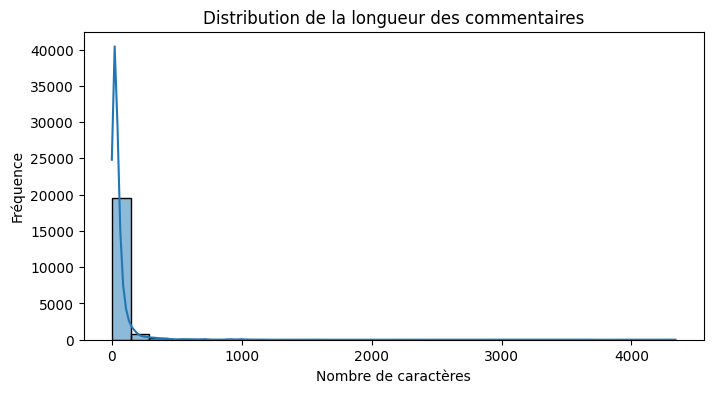

In [28]:

plt.figure(figsize=(8,4))
sns.histplot(comments_df['comment_length'], bins=30, kde=True)
plt.title("Distribution de la longueur des commentaires")
plt.xlabel("Nombre de caractères")
plt.ylabel("Fréquence")
plt.show()

In [33]:
message = comments_df[comments_df["comment_length"] > 4000]["message"].iloc[0]
print(message)


سبحان الله و الحمدلله و لا إله إلا الله و الله أكبر ولا حول ولاقوة الا بالله العلي العظيم. اللهم صل وسلم على نبينا محمد. سبحان الله وبحمده سبحان الله العظيم.#مليارات_الحسنات_لا_تعد_ولا_تحصى إغتنموا ثوابها#
🔸سبحان الله عدد ماخلق
🔸سبحان الله ملء ماخلق
🔸سبحان الله عدد مافي السموات والارض
🔸سبحان الله ملء مافي السموات والارض
🔸سبحان الله عدد ما أحصى كتابه
🔸 سبحان الله ملء ما أحصى كتابه
🔸سبحان الله عدد كل شيء
🔸سبحان الله ملء كل شيء
🔸سبحان الله عدد خلقه ورضا نفسه وزنة عرشه ومداد كلماته 
🔶سبحان الله عدد ورق الأشجار وعدد حصي الجبال
 وعدد قطرات الأمطار وعدد حبات الرمال 
🔹لا إله إلا الله عدد ما خلق
🔹لا إله إلا الله ملء ما خلق
🔹لا إله إلا الله عدد مافي السموات والأرض
🔹لا إله إلا الله ملء مافي السموات والأرض
🔹لا إله إلا الله عدد ما أحصى كتابه 
🔹لا إله إلا الله ملء ما أحصى كتابه
🔹لا إله إلا الله عدد كل شيء 
🔹لا إله إلا الله ملء كل شيء
🔹لا إله إلا الله عدد خلقه ورضا نفسه وزنة عرشه ومداد كلماته
🔷لا إله إلا الله عدد ورق الأشجار وعدد حصي الجبال وعدد قطرات الأمطار وعدد حبات الرمال 
🔸الحمد لله عدد ماخلق
🔸ا

In [ ]:
# 1. Colonnes texte à vérifier
text_fields = [
    "comment_id", "user_id", "user_name", "message", "created_time"
]

print("🧪 Champs texte vides (commentaires) :")
for col in text_fields:
    empty_count = (comments_df[col].astype(str).str.strip() == '').sum()
    print(f" - {col}: {empty_count} lignes vides")

# 2. Vérification created_time valide
print("\n🕒 Vérification des timestamps invalides (commentaires) :")
invalid_dates = pd.to_datetime(comments_df["created_time"], errors="coerce").isna().sum()
print(f" - created_time non valides : {invalid_dates}")

# 3. Valeurs uniques des booléens (si existent, ex: can_like, peut être adapté à ton cas)
bool_fields = [col for col in ["can_like"] if col in comments_df.columns]

print("\n🔁 Valeurs uniques booléennes (commentaires) :")
for col in bool_fields:
    print(f" - {col}: {comments_df[col].nunique()} valeurs uniques ({comments_df[col].unique()})")

# 4. Champs numériques : valeurs à 0
numeric_fields = [col for col in ["like_count", "reply_count"] if col in comments_df.columns]

print("\n🔢 Champs numériques avec des zéros (commentaires) :")
for col in numeric_fields:
    zero_count = (comments_df[col] == 0).sum()
    print(f" - {col} == 0 : {zero_count} lignes")

# 5. Listes : hashtags et mentions dans les commentaires (si présents)
list_fields = [col for col in ["hashtags", "mentions"] if col in comments_df.columns]

print("\n📚 Vérification des champs listes (commentaires) :")
for col in list_fields:
    non_lists = comments_df[~comments_df[col].apply(lambda x: isinstance(x, list))].shape[0]
    empty_lists = comments_df[comments_df[col].apply(lambda x: isinstance(x, list) and len(x) == 0)].shape[0]
    print(f" - {col} : {non_lists} non-listes / {empty_lists} listes vides")

🧪 Champs texte vides (commentaires) :
 - comment_id: 0 lignes vides
 - user_id: 0 lignes vides
 - user_name: 0 lignes vides
 - message: 466 lignes vides
 - created_time: 0 lignes vides

🕒 Vérification des timestamps invalides (commentaires) :
 - created_time non valides : 0

🔁 Valeurs uniques booléennes (commentaires) :

🔢 Champs numériques avec des zéros (commentaires) :
 - like_count == 0 : 16570 lignes
 - reply_count == 0 : 16336 lignes

📚 Vérification des champs listes (commentaires) :
